# Package management

In [1]:
# Import modules
import importlib
import tensorflow as tf
tf.keras.backend.set_floatx('float64') # If reconstruction precision is too low, increase the precision here
from gyoza.modelling import flow_layers as mfl
from gyoza.modelling import masks as gmm
from gyoza.modelling import standard_layers as msl
from gyoza.utilities import math as gum
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from typing import List
from gyoza.modelling import data_iterators as mdis
import shutil
import random
plt.rcParams["font.family"] = "Times New Roman"

2023-07-13 17:48:58.924013: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Reload custom modules
importlib.reload(mfl)
importlib.reload(gmm)
importlib.reload(msl)
importlib.reload(gum)
importlib.reload(mdis)

<module 'gyoza.modelling.data_iterators' from '/Users/timdick/Documents/gyoza/gyoza/src/gyoza/modelling/data_iterators.py'>

# Configuration

In [8]:
tf.keras.backend.set_floatx('float64') # If reconstruction precision is too low, increase the precision here
np.random.seed(14)
tf.random.set_seed(21)
random.seed(380)

# Data Synthesis

In [9]:
# Create manifolds

# 1. Generate equally spaced points along a line of length S
golden_ratio = (1 + 5 ** 0.5) / 2
beta = np.log(golden_ratio)/(np.pi/2) # https://en.wikipedia.org/wiki/Golden_spiral see section on mathematics
S = (1*np.sqrt(1+beta**2)/beta)*(np.exp(beta*2*np.pi)-1) # https://www.quora.com/What-is-the-arc-length-of-the-logarithmic-spiral-from-t0-to-t the arc length of the golden spiral for one full rotation
s = np.linspace(-S/2,S/2,10, dtype=tf.keras.backend.floatx()) # These points are the steps along any manifold

# 2. Create mathematical functions that map step s along an arc to x and y coordinates
f_1 = lambda s: (np.arcsinh(s), np.sign(np.arcsinh(s)) * np.cosh(np.arcsinh(s)) - np.sign(s))
f_2 = lambda s: gum.rotate(xs=s, ys=0*s, theta=np.arccos((f_1(S/2)[1]/ f_1(S/2)[0]) / np.sqrt(f_1(S/2)[0]**2 + f_1(S/2)[1]**2))) # this theta leads to same slope as the cosh function on s

f_3 = lambda s: (s, S*np.sign(s)/4)
def f_4(s):
    half_1 = s[np.where(s <  0)]
    half_2 = s[np.where(0 <= s)]

    x = np.concatenate([half_1, half_2 - S/4]) + 1*S/8
    y = np.array([1*S/4]* len(half_1) + [3*S/4] * len(half_2)) - S/2

    return x, y

f_5 = lambda s: ((S/(2*np.pi))* np.sin((s+S/2)*(2*np.pi)/S), (S/(2*np.pi))*np.cos((s+S/2)*(2*np.pi)/S))
f_6 = lambda s: gum.logarithmic_spiral(xs=np.log((s+S/2)/(1*np.sqrt(1+beta**2)/beta)+1)/beta, alpha=1, beta=beta) # https://www.quora.com/What-is-the-arc-length-of-the-logarithmic-spiral-from-t0-to-t

# 3. Select a manifold
f_name = 'f_1'
exec(f'f_raw = {f_name}') # Function name is needed for plotting later on

# 4. Add noise
noise_strength = 0.5
noise_function = lambda x, y: (x+ noise_strength * np.random.standard_normal(size=y.shape), y + noise_strength * np.random.standard_normal(size=y.shape))
f = lambda x: noise_function(*f_raw(x))

# 5. Generate data
Y = np.concatenate([np.zeros([len(s),1]), s[:, np.newaxis]], axis=1) # Here the first dimension is zero because deviation from the manifold is not supervised. The second dimension is the step along the manifold 
x_1, x_2 = f(s) # Map onto manifold in 2D plane
X = np.concatenate([x_1[:,np.newaxis], x_2[:,np.newaxis]], axis=1)

# 6. Choose a data iterator
similarity_function = lambda y_a, y_b: np.concatenate([np.zeros([y_a.shape[0],1]), 1 - np.abs(y_a[:,1:2]-y_b[:,1:2])/S], axis=1)
batch_size = 3
iterator = mdis.volatile_factorized_pair_iterator(X=X, Y=Y, batch_size=batch_size, similarity_function=similarity_function)
X_a_b, Y_a_b = next(iterator)
print("A batch has shapes:")
print("X_a_b: (instances, pair, coordinates)", X_a_b.shape)
print("Y_a_b: (instances, factors)          ", Y_a_b.shape)


A batch has shapes:
X_a_b: (instances, pair, coordinates) (3, 2, 2)
Y_a_b: (instances, factors)           (3, 2)


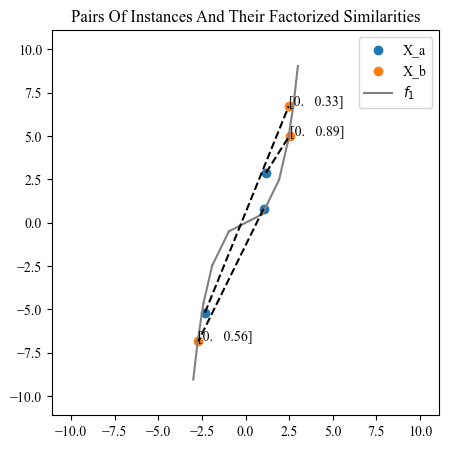

In [13]:
# Plot instances
plt.figure(figsize=(5,5)); plt.title("Pairs Of Instances And Their Factorized Similarities")
    
plt.scatter(X_a_b[:,0,0], X_a_b[:,0,1]) # Instances a
plt.scatter(X_a_b[:,1,0], X_a_b[:,1,1]) # Instances b

for i in range(len(s)-1): plt.plot(*f_raw(s[i:i+2]), color='gray')

plt.legend(['X_a','X_b',rf'${f_name}$'])
for i in range(X_a_b.shape[0]):
    plt.plot([X_a_b[i,0,0], X_a_b[i,1,0]], [X_a_b[i,0,1], X_a_b[i,1,1]], '--', color='black')
    plt.text(X_a_b[i,1,0], X_a_b[i,1,1], str(np.round(Y_a_b[i], 2)))
plt.ylim(-S/1.8,S/1.8); plt.xlim(-S/1.8,S/1.8)
plt.show()

# Model Creation

# Model Calibration

In [ ]:
# Data iterator
similarity_function = lambda y_a, y_b: np.concatenate([np.zeros([y_a.shape[0],1]), 1 - np.abs(y_a[:,1:2]-y_b[:,1:2])/S], axis=1)
data_iterator = mdis.volatile_factorized_pair_iterator(X=X, Y=Y, batch_size=batch_size, similarity_function=similarity_function)
X_a_b, Y_a_b = next(data_iterator)
print("A batch has shapes:")
print("X_a_b: (instances, pair, coordinates)", X_a_b.shape)
print("Y_a_b: (instances, factors)          ", Y_a_b.shape)
del data_iterator # Will be reinstantiated during calibration

# Model Testing

# Model Saving